# Domain adaptation for fault diagnosis: A CWRU toy example
This is a toy DA example for the CWRU dataset. You can check [this paper](https://arxiv.org/pdf/1905.06004) for more details.

Qin Wang @ ETH Zurich 

This notebook was used as part of my tutorial session for the European conference of the prognosticas and health management society (PHME21). 



Please cite our work if you find this notebook useful:

```latex
@inproceedings{wang2019domain,
  title={Domain adaptive transfer learning for fault diagnosis},
  author={Wang, Qin and Michau, Gabriel and Fink, Olga},
  booktitle={2019 Prognostics and System Health Management Conference (PHM-Paris)},
  pages={279--285},
  year={2019},
  organization={IEEE}
}
@article{wang2020missing,
  title={Missing-class-robust domain adaptation by unilateral alignment},
  author={Wang, Qin and Michau, Gabriel and Fink, Olga},
  journal={IEEE Transactions on Industrial Electronics},
  volume={68},
  number={1},
  pages={663--671},
  year={2020},
  publisher={IEEE}
}
```

## Load Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Conv1D, Flatten, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K


## Download the data


In [ ]:
!wget https://qin.ee/bearings/X.npy
!wget https://qin.ee/bearings/X-test.npy
!wget https://qin.ee/bearings/y.npy
!wget https://qin.ee/bearings/y-test.npy

--2021-06-30 09:45:24--  https://qin.ee/bearings/X.npy
Resolving qin.ee (qin.ee)... 35.177.27.26
Connecting to qin.ee (qin.ee)|35.177.27.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8192128 (7.8M) [application/octet-stream]
Saving to: ‘X.npy’

X.npy               100%[===================>]   7.81M  6.53MB/s    in 1.2s    

2021-06-30 09:45:26 (6.53 MB/s) - ‘X.npy’ saved [8192128/8192128]

--2021-06-30 09:45:26--  https://qin.ee/bearings/X-test.npy
Resolving qin.ee (qin.ee)... 35.177.27.26
Connecting to qin.ee (qin.ee)|35.177.27.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8192128 (7.8M) [application/octet-stream]
Saving to: ‘X-test.npy’

X-test.npy          100%[===================>]   7.81M  6.48MB/s    in 1.2s    

2021-06-30 09:45:28 (6.48 MB/s) - ‘X-test.npy’ saved [8192128/8192128]

--2021-06-30 09:45:29--  https://qin.ee/bearings/y.npy
Resolving qin.ee (qin.ee)... 35.177.27.26
Connecting to qin.ee (qin.ee)|35.177.27.

## Data Loading 
Load source and target data 
+  We have preprocessed the data for you, they are FFT preprocessed vibration data.
+  Source is recorded under load 3 
+  Target is recorded under load 1
+  Each contains 10 classes, out of which 9 are different faults

In [ ]:
data_src = np.load("X.npy")[::10] #10% subset for faster try during the tutorial
label_src = np.load("y.npy")[::10]
data_tgt = np.load("X-test.npy")[::10]
label_tgt = np.load("y-test.npy")[::10]
print("Source dimension", data_src.shape, label_src.shape)
print("Target dimension", data_tgt.shape, label_tgt.shape)


Source dimension (200, 1024) (200,)
Target dimension (200, 1024) (200,)


Get the data FFT transformed


In [ ]:
fft = lambda sig: abs(np.fft.fft(sig)[:len(sig)//2])
data_src_fft = np.array([fft(sig) for sig in data_src])
data_tgt_fft = np.array([fft(sig) for sig in data_tgt])
print("Source dimension", data_src_fft.shape, label_src.shape)
print("Target dimension", data_tgt_fft.shape, label_tgt.shape)

Source dimension (200, 512) (200,)
Target dimension (200, 512) (200,)


In [ ]:
### Expand the last dimension for ease of feeding conv1d
data_src = np.expand_dims(data_src, axis=-1)
data_src_fft = np.expand_dims(data_src_fft, axis=-1)
data_tgt = np.expand_dims(data_tgt, axis=-1)
data_tgt_fft = np.expand_dims(data_tgt_fft, axis=-1)
print("Source dimension", data_src_fft.shape, data_src.shape)
print("Target dimension", data_tgt_fft.shape, data_tgt.shape)

Source dimension (200, 512, 1) (200, 1024, 1)
Target dimension (200, 512, 1) (200, 1024, 1)


### Let's check the data first 
First let's visualize some samples from source. 

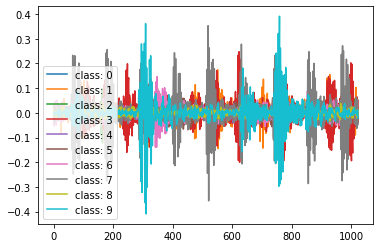

In [ ]:
# Have a taste of data, the given target data is in order..
for i in range(10):
    plt.plot(data_tgt[20*i], label="class: " + str(i))
    assert(label_tgt[20*i] == i)
plt.legend()

Then visulize the FFT-ed target signals.

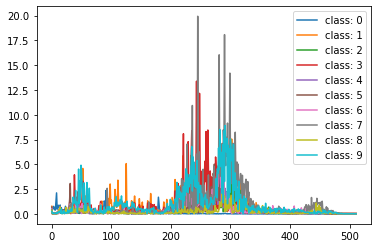

In [ ]:
for i in range(10):
    plt.plot(data_tgt_fft[20*i], label="class: " + str(i))
    assert(label_tgt[20*i] == i)
plt.legend()

## **Example** A source-only baseline model is provided.



In [ ]:
def feature_extractor(x):
    h = Conv1D(10, 3, padding='same', activation="relu")(x)
    h = Dropout(0.5)(h)
    h = Conv1D(10, 3, padding='same', activation="relu")(h)
    h = Dropout(0.5)(h)
    h = Conv1D(10, 3, padding='same', activation="relu")(h)
    h = Dropout(0.5)(h)
    h = Flatten()(h)
    h = Dense(256, activation='relu')(h)
    return h
    
def clf(x):    
    h = Dense(256, activation='relu')(x)
    h = Dense(10, activation='softmax', name="clf")(h)
    return h

def baseline():
    input_dim = 512    
    inputs = Input(shape=(input_dim, 1))
    features = feature_extractor(inputs)
    logits = clf(features)
    baseline_model = Model(inputs=inputs, outputs=logits)
    adam = Adam(lr=0.0001)
    baseline_model.compile(optimizer=adam,
              loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
    return baseline_model

# Set seed
accs = []
import random as python_random
for i in range(10):
    python_random.seed(i)
    np.random.seed(i)
    tf.random.set_seed(i)
    baseline_model = baseline()
    # Run training 
    baseline_model.fit(data_src_fft, label_src, batch_size=128, epochs=400, shuffle=True, verbose=False)
    # Run evaluating
    score, acc = baseline_model.evaluate(data_tgt_fft, label_tgt, batch_size=200)
    print("Accuracy for the baseline model on target data is", acc)
    accs.append(acc)
print("ten run mean", np.mean(accs))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 0s 171ms/step - loss: 0.2753 - accuracy: 0.9050
Accuracy for the baseline model on target data is 0.9049999713897705
1/1 [==============================] - 0s 114ms/step - loss: 0.3429 - accuracy: 0.8900
Accuracy for the baseline model on target data is 0.8899999856948853
1/1 [==============================] - 0s 112ms/step - loss: 0.2147 - accuracy: 0.9100
Accuracy for the baseline model on target data is 0.9100000262260437
1/1 [==============================] - 0s 114ms/step - loss: 0.3670 - accuracy: 0.8300
Accuracy for the baseline model on target data is 0.8299999833106995
1/1 [==============================] - 0s 126ms/step - loss: 0.2573 - accuracy: 0.8800
Accuracy for the baseline model on target data is 0.8799999952316284
1/1 [==============================] - 0s 121ms/step - loss: 0.3998 - accuracy: 0.8350
Accuracy for the baseline model on target data is 0.8349999785423279
1/1 [==============================] - 0s 118ms/step - loss: 0.2

## Task: Domain Adversarial Training!
Let's now add domain adversarial ability to the baseline model. First we need to define the gradient reverse layer, because it is a custom op. 

### **TODO** Gradient Reverse Layer(GRL) Layer 

---


Define a custom keras layer GradReverse which can change the normal gradient to our expected reserved ones.
Check the [GRL](https://arxiv.org/pdf/1409.7495) paper whenever necessary.
Since we are customizing the layer, we will need some backend ops to reverse the gradient. 

Hint: For example, you can use [this decorator](https://www.tensorflow.org/api_docs/python/tf/custom_gradient) to customize the gradient.



In [ ]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

#### We now provide you with a simple discriminator which you could use for the domain adversarial training. 



In [ ]:
def discriminator(x):    
    h = Dense(1024, activation='relu')(x)
    h = Dense(1024, activation='relu')(h)
    h = Dense(2, activation='softmax', name="dis")(h)
    return h


### **TODO** Training strategy
Now it's time to add the discriminator to the network and see how it works. 
We provide you with some hints in the comments but feel free to write the code in your own ways as long as it is a correct alignment. 


In [ ]:
def grl():
    """ GRL strategy
    returns: the classification branch, the discriminator branch
    """
    input_dim = 512
    
    ### Define inputs
    inputs = Input(shape=(input_dim, 1))
    ### Get features
    features = feature_extractor(inputs)
    ### Get classification logits
    logits = clf(features)
    ### Define the classification branch model
    clf_branch = Model(inputs=inputs, outputs=logits)
    adam = Adam(lr=0.0001)   
    clf_branch.compile(optimizer=adam,
              loss={'clf': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    
    ### Define the classification branch model    
    features_rev = GradReverse()(features)
    logits_da = discriminator(features_rev)

    da_branch = Model(inputs=inputs, outputs=logits_da)
    adam_da = Adam(lr=0.0001)   
    da_branch.compile(optimizer=adam_da,
              loss={'dis': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return clf_branch, da_branch

### **TODO** Make it run! 
Add the training code for the above model.


In [ ]:
### Some constants
NUM_EPOCH = 400
BATCH_SIZE = 128
DATASET_SIZE = 200

accs = []
import random as python_random
for i in range(10):
    python_random.seed(i)
    np.random.seed(i)
    tf.random.set_seed(i)
    clf_branch, da_branch = grl()
    ### Iterate over 
    for i in range(NUM_EPOCH * (DATASET_SIZE // BATCH_SIZE)):
        ### Randomly fetch training data
        idx_src = np.random.choice(DATASET_SIZE, size=BATCH_SIZE, replace=False)
        idx_tgt = np.random.choice(DATASET_SIZE, size=BATCH_SIZE, replace=False)
        batch_src, batch_y = data_src_fft[idx_src], label_src[idx_src]
        ### We don't use any label from target domain
        batch_tgt = data_tgt_fft[idx_tgt] 
        ########## the training code for clf_branch ###################
        clf_branch.train_on_batch(batch_src, batch_y)
        ########## the training code for discriminator branch #########
        dis_y = np.concatenate([np.zeros_like(batch_y), np.ones_like(batch_y)], axis=0)
        da_branch.train_on_batch(np.concatenate([batch_src, batch_tgt], axis=0), dis_y)

    ### Final results
    score, acc = clf_branch.evaluate(data_tgt_fft, label_tgt, batch_size=200)
    print("Final Accuracy", acc)
    accs.append(acc)
print("ten run mean", np.mean(accs))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 0s 121ms/step - loss: 0.1550 - accuracy: 0.9750
Final Accuracy 0.9750000238418579
1/1 [==============================] - 0s 121ms/step - loss: 0.1089 - accuracy: 0.9900
Final Accuracy 0.9900000095367432
1/1 [==============================] - 0s 113ms/step - loss: 0.0578 - accuracy: 0.9950
Final Accuracy 0.9950000047683716
1/1 [==============================] - 0s 123ms/step - loss: 0.0788 - accuracy: 0.9900
Final Accuracy 0.9900000095367432
1/1 [==============================] - 0s 118ms/step - loss: 0.0952 - accuracy: 0.9950
Final Accuracy 0.9950000047683716
1/1 [==============================] - 0s 122ms/step - loss: 0.1750 - accuracy: 0.9650
Final Accuracy 0.9649999737739563
1/1 [==============================] - 0s 113ms/step - loss: 0.0934 - accuracy: 0.9850
Final Accuracy 0.9850000143051147
1/1 [==============================] - 0s 137ms/step - loss: 0.0764 - accuracy: 0.9950
Final Accuracy 0.9950000047683716
1/1 [===========================

## Adversarially aligned model perform better than source-only for the CWRU dataset!